In [10]:
import pandas, numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_bloch_multivector

## Introduction

Our goal is to analyze the efficiencies and make resource comparisons between second-quantization and Hermite encodings for quantum computing. Below, I shall construct code that uses both types of encodings to implement the following Hamiltonian structure: 
$$ H = \frac{P^2}{2m}+\frac{1}{2}Mw^2X^2$$
In our unitary time evolution, we wish to consider terms of the form:
$$e^{-i\theta\tilde{X^2}}\text{, }e^{-i\theta (\tilde{X}^2+\tilde{P}^2)}$$

where the "~" denotes the pseudo-Hilbert space position operator acting on our discretized subspace representation of the quantum harmonic oscillator.



In the Hermite encoding, we work in either a position or momentum eigenbasis, allowing us to easily act with our time evolution operator, as follows:

$$\bullet \text{  } e^{-i\theta\tilde{X}} |x_n\rangle = e^{-i2^{n_x-1}\theta}e^{-i(x_n-2^{n_x-1})\theta}|x_n\rangle\\
\bullet \text{  } e^{-i\theta\tilde{X^2}} |x_n\rangle = e^{i2^{2n_x-2}\theta}e^{-i(x_n-2^{n_x-1})^2 \theta}|x_n\rangle
$$

For $P^2$, we simply perform QFT to go to the momentum basis, where we can perform the analagous operation, and then do inverse QFT to return to the original position basis.

Macridin et al then demonstrated that these operators can be implemented using T and CT gates, e.g. for $e^{-i\theta\tilde{X^2}}$, we require $\frac{n_x (n_x-1)}{2}$ CT gates.

Note: In my overall calculation for the $X^2+P^2$ operator, I claim that, since the action of $X^2$ in the position basis is equivalent to $P^2$ in the momentum basis, the total number of CT gates needed will be twice that as stated above. I am not considering operations involved in the QFT and inverse QFT.

What we now wish to do is convert the operator $e^{-i\theta (X^2+P^2)}$ into second-quantisation form, follow the  outline from Sawaya et al, and determine the number of CNOT gates required to implement the Hamiltonian.

I follow the following procedure:
1. Rewrite the Hamiltonian: 
$$H=f(x) \rightarrow H=\sum_{l,l'=0}^{d-1}|l\rangle\langle l'| = \sum_{k}c_k \bigotimes_j \sigma_{kj} = \sum_{k}h_k$$
2. After writing the Hamiltonian as a sum of Pauli strings, we then apply Suzuki-Trotter:
$$\hat{U}(t)=e^{-iHt}=e^{-it\sum h_k} \approx \left(\Pi_k e^{\frac{-ih_{k}t}{\eta}} \right)^\eta=\tilde{U}(t)$$
3. Now, we have $\tilde{U}(t)=\Pi_k e^{\tilde{c_k}\otimes_j \sigma_{kj}}$, i.e. a product of exponentials of Pauli strings. We can then directly apply these exponentials using CNOT gates.
4. We construct a resource comparison between second-quantized and Hermite encoding by understanding how many CNOT gates vs CT gates are required, respectively, for each encoding.\
Note: for p Pauli operators in a Pauli string, exp(Pauli_string) requires $2(p-1)$ CNOT gates [Sawaya et al]

## I. Preparation of the quantum circuit

Initial setup of our circuit:

In [11]:
def init_circ(n_x=2):
    # n_x = number of qubits in our register
    circ = QuantumCircuit(n_x, n_x)
    circ.draw(output='mpl')

## II. Calculation of our position and momentum operator

In second-quantization, our position and momentum operators, $q$,$p$ are given by
$$q=\frac{1}{2}\left(a_j^\dagger + a_j\right)\\
p=\frac{i}{2}\left(a_j^\dagger - a_j\right)$$
where
$$a_j^\dagger |n\rangle = \sqrt{n+1}|n+1\rangle\\
a_j|n\rangle = \sqrt{n}|n-1\rangle$$

Note that by symmetry, $q,p$ have identical sparsity patterns, as do $q^2,p^2$. In other words, though the numerical factors may differ, $q^2$ and $p^2$ will have the same types of non-zero matrix elements.



In [1]:
def second_quantization(n_x):
    num_states = pow(2,n_x)
    print("Total number of states:", num_states, "\n")


    arr_zeros = np.zeros((num_states,1))
    int_basis_matrix = np.zeros((num_states,num_states))
    dict = {} # Our dictionary will contain our integer basis elements e.g. |0> = (1,0,0,0)

    q = np.zeros((num_states,num_states))
    p = np.zeros((num_states,num_states))

    for i in range(num_states):              #constructing the position operator as a matrix
        for j in range(num_states):
            if j==i:
                int_basis_matrix[i][j] = 1
            if j==(i+1): 
                q[i][j] = np.sqrt(j)
                q[j][i] = np.sqrt(j)
                p[i][j] = np.sqrt(j)
                p[j][i] = -np.sqrt(j)
        dict[i] = int_basis_matrix[:,i] # Seems to work, but is questionable
            
        
    #print(q)
    #print("q^2=\n",np.square(q))
    q = q/np.sqrt(2)
    p = (complex(0,1)/np.sqrt(2)) * p

    q_sq = np.matmul(q,q)
    q_sq[-1][-1] += num_states/2 # the last element needs to be corrected due to X matrix being truncated

    p_sq = np.matmul(p,p)
    p_sq[-1][-1] -= num_states/2 # the last element needs to be corrected due to X matrix being truncated

    op_sq = q_sq+p_sq
    #print(op_sq)

    #print("\n",dict)
    #print(q, "\n\n\n", q_sq)
    return num_states, q, q_sq, p_sq, op_sq



We now have
$$q=a_{ij}|i\rangle\langle j|\\
p=b_{ij}|i\rangle\langle j|$$
Next, we need to translate from matrix form into a particular choice of encoding, e.g. standard binary, gray, unary.

In [2]:
# Standard Binary

def convert_to_std_bin(n_x, num_states, q, q_sq, p_sq, op_sq):
    std_bin_dict = {} # std bin basis
    q_std_bin = {} # dictionary containing q values/coeffs with their binary basis representation as the key
    q_sq_std_bin = {}
    op_sq_std_bin = {}

    for i in range(num_states):              
        std_bin_dict[f"{i:02b}"] = dict[i]  # CAREFUL: f"{i:02b}" converts i to binary and pads to 2 digits, not n_x digits
        for j in range(num_states):
            if j >= i:
                # if q[i][j]!=0:
                #     q_std_bin[f"{i:02b}.{j:02b}+{j:02b}.{i:02b}"]=q[i][j]
                # if q_sq[i][j]!=0 and i!=j:
                #     q_sq_std_bin[f"{i:02b}.{j:02b}+{j:02b}.{i:02b}"]=q_sq[i][j]
                # elif q_sq[i][j]!=0 and i==j:
                #     q_sq_std_bin[f"{i:02b}.{j:02b}"]=q_sq[i][j]
                # if op_sq[i][j]!=0 and i!=j:
                #     op_sq_std_bin[f"{i:02b}.{j:02b}+{j:02b}.{i:02b}"]=op_sq[i][j]
                # elif op_sq[i][j]!=0 and i==j:
                #     op_sq_std_bin[f"{i:02b}.{j:02b}"]=op_sq[i][j]
                
                if q[i][j] != 0:
                    q_std_bin[f"{i:0{n_x}b}.{j:0{n_x}b}+{j:0{n_x}b}.{i:0{n_x}b}"] = q[i][j]
                if q_sq[i][j] != 0 and i != j:
                    q_sq_std_bin[f"{i:0{n_x}b}.{j:0{n_x}b}+{j:0{n_x}b}.{i:0{n_x}b}"] = q_sq[i][j]
                elif q_sq[i][j] != 0 and i == j:
                    q_sq_std_bin[f"{i:0{n_x}b}.{j:0{n_x}b}"] = q_sq[i][j]
                if op_sq[i][j] != 0 and i != j:
                    op_sq_std_bin[f"{i:0{n_x}b}.{j:0{n_x}b}+{j:0{n_x}b}.{i:0{n_x}b}"] = op_sq[i][j]
                elif op_sq[i][j] != 0 and i == j:
                    op_sq_std_bin[f"{i:0{n_x}b}.{j:0{n_x}b}"] = op_sq[i][j]
    
    #std_bin_dict
    #q_std_bin
    #q_sq_std_bin
    return std_bin_dict, q_std_bin, q_sq_std_bin, op_sq_std_bin




# Gray

# Unary


E.g. for standard binary, We can now think of $q$ as 
$$q = a_{ij}|i_{\text{binary}}\rangle\langle j_{\text{binary}}|$$
We now want to break up the binary representation into tensor products, e.g. 
$|00\rangle\langle 01| = |0\rangle\langle 1|^{(0)} \otimes |0\rangle\langle 0|^{(1)}$
where the superscript denotes qubit number.

In [3]:

def tensor_product_decomp(std_bin_dict, q_std_bin, q_sq_std_bin, op_sq_std_bin):
    std_bin_dict_2 = {}
    std_bin_dict_3 = {} # for X operator

    sq_std_bin_dict_2 = {}
    sq_std_bin_dict_3 = {} # for X^2 operator

    op_sq_std_bin_dict_2 = {}
    op_sq_std_bin_dict_3 = {} # for X^2+P^2 operator





    # For X:
    for key in q_std_bin:
        #print(key)
        components = key.split("+") # components will always be a list with 2 sublists (symmetric)
        for i in components:
            left = i.split(".")[0]
            right = i.split(".")[1]
            length = len(left) # len(left) should be equal to len(right)
            subkey = ""
        
            for j in range(length):  # breaking up into sum of products of single qubits
                if subkey == "":
                    subkey = left[length-j-1] + "." + right[length-j-1]
                else:
                    subkey += "*" + left[length-j-1] + "." + right[length-j-1]
             
            std_bin_dict_2[subkey] = q_std_bin[key]

    for key in std_bin_dict_2:    # removing duplicates from the dictionary
        for key2 in std_bin_dict_2:
            if ((key != key2) and (std_bin_dict_2[key]==std_bin_dict_2[key2])):
                if std_bin_dict_2[key] not in std_bin_dict_3.values():
                    std_bin_dict_3[key+ "+" +key2] = std_bin_dict_2[key]

                
                
                
    # For X^2:
    for key in q_sq_std_bin:
        #print(key)
        components = key.split("+") # components will always be a list with 2 sublists (symmetric)
        #print(components)
        for i in components:
            left = i.split(".")[0]
            right = i.split(".")[1]
            length = len(left) # len(left) should be equal to len(right)
            subkey = ""
        
            for j in range(length):  # breaking up into sum of products of single qubits
                if subkey == "":
                    subkey = left[length-j-1] + "." + right[length-j-1]
                else:
                    subkey += "*" + left[length-j-1] + "." + right[length-j-1]
             
            if len(components)==1:
                sq_std_bin_dict_2[subkey] = -1*q_sq_std_bin[key] ## CAUTION: Intentionally adding a minus sign to the value in the dictionary here
            else:
                sq_std_bin_dict_2[subkey] = q_sq_std_bin[key] 
            
            
    for key in sq_std_bin_dict_2:    # removing duplicates from the dictionary
        for key2 in sq_std_bin_dict_2:
            if ((key != key2) and (sq_std_bin_dict_2[key]==sq_std_bin_dict_2[key2])):
                if sq_std_bin_dict_2[key] not in sq_std_bin_dict_3.values():
                    sq_std_bin_dict_3[key+ "+" +key2] = sq_std_bin_dict_2[key]
            elif key==key2  and (sq_std_bin_dict_2[key]<0) and(sq_std_bin_dict_2[key] not in sq_std_bin_dict_3.values()):
                sq_std_bin_dict_3[key] = sq_std_bin_dict_2[key]

            
    # Removing the minus signs
    for key in sq_std_bin_dict_3:
        if sq_std_bin_dict_3[key]<0:
            sq_std_bin_dict_3[key] = -1*sq_std_bin_dict_3[key]
        
    #std_bin_dict_3
    #sq_std_bin_dict_3
    # q_std_bin






    # For X^2+P^2:
    for key in op_sq_std_bin:
        #print(key)
        components = key.split("+") # components will always be a list with 2 sublists (symmetric)
        #print(components)
        for i in components:
            left = i.split(".")[0]
            right = i.split(".")[1]
            length = len(left) # len(left) should be equal to len(right)
            subkey = ""
        
            for j in range(length):  # breaking up into sum of products of single qubits
                if subkey == "":
                    subkey = left[length-j-1] + "." + right[length-j-1]
                else:
                    subkey += "*" + left[length-j-1] + "." + right[length-j-1]
             
            if len(components)==1:
                op_sq_std_bin_dict_2[subkey] = -1*op_sq_std_bin[key] ## CAUTION: Intentionally adding a minus sign to the value in the dictionary here
            else:
                op_sq_std_bin_dict_2[subkey] = op_sq_std_bin[key] 
            
            
    for key in op_sq_std_bin_dict_2:    # removing duplicates from the dictionary
        for key2 in op_sq_std_bin_dict_2:
            if ((key != key2) and (op_sq_std_bin_dict_2[key]==op_sq_std_bin_dict_2[key2])):
                if op_sq_std_bin_dict_2[key] not in op_sq_std_bin_dict_3.values():
                    op_sq_std_bin_dict_3[key+ "+" +key2] = op_sq_std_bin_dict_2[key]
            elif key==key2  and (op_sq_std_bin_dict_2[key]<0) and(op_sq_std_bin_dict_2[key] not in op_sq_std_bin_dict_3.values()):
                op_sq_std_bin_dict_3[key] = op_sq_std_bin_dict_2[key]

            
    # Removing the minus signs
    for key in op_sq_std_bin_dict_3:
        if op_sq_std_bin_dict_3[key]<0:
            op_sq_std_bin_dict_3[key] = -1*op_sq_std_bin_dict_3[key]
        



    return std_bin_dict_3, sq_std_bin_dict_3, op_sq_std_bin_dict_3

#X:
# n=2 example should produce the following:
# {'q0*q1+q0*q1': value}
# {'0.1*0.0+1.0*0.0': 0.7071067811865475,
#  '1.0*0.1+0.1*1.0': 1.0,
#  '0.1*1.1+1.0*1.1': 1.224744871391589}


# # n=3 example produces the following:
# {'0.1*0.0*0.0+1.0*0.0*0.0': 0.7071067811865475,
#  '1.0*0.1*0.0+0.1*1.0*0.0': 1.0,
#  '0.1*1.1*0.0+1.0*1.1*0.0': 1.224744871391589,
#  '1.0*1.0*0.1+0.1*0.1*1.0': 1.414213562373095,
#  '0.1*0.0*1.1+1.0*0.0*1.1': 1.5811388300841895,
#  '1.0*0.1*1.1+0.1*1.0*1.1': 1.732050807568877,
#  '0.1*1.1*1.1+1.0*1.1*1.1': 1.8708286933869707}




#X^2:
#n=2"
# {'0.0*0.0': 0.4999999999999999,
#  '0.0*0.1+0.0*1.0': 0.7071067811865475,
#  '1.1*0.0': 1.5,
#  '1.1*0.1+1.1*1.0': 1.224744871391589,
#  '0.0*1.1': 2.4999999999999996,
#  '1.1*1.1': 3.5}


## III. Conversion to Pauli Strings

After conversion to a particular encoding choice, we now employ the following relations from Sawaya et al to convert into a sum of Pauli strings.

$$ |0\rangle\langle1| = \frac{1}{2}\left(\sigma_x + i\sigma_y\right)\\
|1\rangle\langle0| = \frac{1}{2}\left(\sigma_x - i\sigma_y\right)\\
|0\rangle\langle0| = \frac{1}{2}\left(1 + \sigma_z\right)\\
|1\rangle\langle1| = \frac{1}{2}\left(1 - \sigma_z\right)$$

In [4]:
# For X:
def convert_X_to_Pauli_string(std_bin_dict_3):
    Pauli_dict = {}

    for key in std_bin_dict_3:
        components = key.split("+") # components will always be a list with 2 sublists (from symmetric off diagonal matrix)
    
        list2 = []
        list3 = []
        for i in components:
            #print(i)
            subterms = i.split("*") # splits into n_x single qubit terms
            aux_list = []
            for j in subterms:      # Implementing the relations above ***NOTE: we are not tracking factor of .5 
                k = []
                if j == "0.1":
                    k = ["x","iy"]
                elif j == "1.0":
                    k = ["x","-iy"]
                elif j == "0.0":
                    k = ["1","z"]
                elif j == "1.1":
                    k = ["1","-z"]
                aux_list.append(k)
            #print(aux_list)
        
            # Now, combine terms in aux_list
            list1 = []
            for a in range(2):
                list1.append(aux_list[0][a])
            #print(list1)
        
        
            b = 1
            while b < len(aux_list):
                new_list=[]
                for index in range(len(list1)):
                    for c in range(2):
                        new_list.append(list1[index] + aux_list[b][c])
                list1 = new_list
                b+=1
           
               
            #print("list1 before is: ", list1)
            # Simplify the elements in list1
            for index in range(len(list1)):
                num_i = 0
                num_minus = 0
                for character in list1[index]:
                    # factors of i
                    if character == "i":
                        num_i+=1
                    # factors of -
                    if character == "-":
                        num_minus+=1
             
                list1[index]=list1[index].replace("i","")
                list1[index]=list1[index].replace("-","")
                if num_i%4 == 1:
                    list1[index] = "i" + list1[index]
                if num_i%4 == 2:
                    num_minus+=1
                if num_i%4 == 3:
                    num_minus+=1
                    list1[index] = "i" + list1[index]
                if num_minus%2 == 1:
                    list1[index] = "-" + list1[index]
           # print("list1 after is: ", list1)
    
        
            list2.append(list1)
        
        #print("list2 is: ", list2)
        
        # Cancel terms in list 2 (list2 will always have 2 sublists)
        illegal = []
        for term in range(len(list2[0])):
            check = ""
            if list2[0][term][0] == "-":
                check = list2[0][term].replace("-","")
                for term2 in range(len(list2[1])):
                    item = ""
                    item = list2[1][term2]
                    if item == check:
                        illegal.append(item)
                        illegal.append("-"+item)
                    
      
            else:
                check = list2[0][term]
                for term2 in range(len(list2[1])):
                    item = ""
                    if list2[1][term2][0] == "-":
                        item = list2[1][term2].replace("-","")
                        if item == check:
                            illegal.append(item)
                            illegal.append("-"+item)

                    else:
                        item = list2[1][term2]
                    
        for term in range(len(list2[0])):
            item = ""
            item = list2[0][term]
            if ((item not in list3) and (item not in illegal)):
                list3.append(item)
    
       # print("list3 is: ", list3)
    
        Pauli_key = ""
        for term in range(len(list3)):
            if Pauli_key == "":
                Pauli_key += list3[term]
            elif list3[term][0]=="-":
                Pauli_key += list3[term]
            else:
                Pauli_key += "+" + list3[term]
                
        Pauli_dict[Pauli_key] = std_bin_dict_3[key]    #NOTE: not taking into account numberical factors from combining terms

    #Pauli_dict


    return Pauli_dict




                    

In [5]:
# For X^2:
def convert_X_sq_to_Pauli_string(sq_std_bin_dict_3):
    sq_Pauli_dict = {}

    for key in sq_std_bin_dict_3:
        components = key.split("+") # components will always be a list with 2 sublists (from symmetric off diagonal matrix)
    
        list2 = []
        list3 = []
        for i in components:
            #print(i)
            subterms = i.split("*") # splits into n_x single qubit terms
            aux_list = []
            for j in subterms:      # Implementing the relations above ***NOTE: we are not tracking factor of .5 
                k = []
                if j == "0.1":
                    k = ["x","iy"]
                elif j == "1.0":
                    k = ["x","-iy"]
                elif j == "0.0":
                    k = ["1","z"]
                elif j == "1.1":
                    k = ["1","-z"]
                aux_list.append(k)
            #print(aux_list)
        
            # Now, combine terms in aux_list
            list1 = []
            for a in range(2):
                list1.append(aux_list[0][a])
            #print(list1)
        
        
            b = 1
            while b < len(aux_list):
                new_list=[]
                for index in range(len(list1)):
                    for c in range(2):
                        new_list.append(list1[index] + aux_list[b][c])
                list1 = new_list
                b+=1
           
               
            #print("list1 before is: ", list1)
            # Simplify the elements in list1
            for index in range(len(list1)):
                num_i = 0
                num_minus = 0
                for character in list1[index]:
                    # factors of i
                    if character == "i":
                        num_i+=1
                    # factors of -
                    if character == "-":
                        num_minus+=1
             
                list1[index]=list1[index].replace("i","")
                list1[index]=list1[index].replace("-","")
                if num_i%4 == 1:
                    list1[index] = "i" + list1[index]
                if num_i%4 == 2:
                    num_minus+=1
                if num_i%4 == 3:
                    num_minus+=1
                    list1[index] = "i" + list1[index]
                if num_minus%2 == 1:
                    list1[index] = "-" + list1[index]
           # print("list1 after is: ", list1)
    
        
            list2.append(list1)
        
        #print("list2 is: ", list2)
        
        # Cancel terms in list 2 (list2 will NOT always have 2 sublists, since we now have diagonal elements)
        illegal = []
        if len(components)==2: #Only need to check these
            for term in range(len(list2[0])):
                check = ""
                if list2[0][term][0] == "-":
                    check = list2[0][term].replace("-","")
                    for term2 in range(len(list2[1])):
                        item = ""
                        item = list2[1][term2]
                        if item == check:
                            illegal.append(item)
                            illegal.append("-"+item)
                    
      
                else:
                    check = list2[0][term]
                    for term2 in range(len(list2[1])):
                        item = ""
                        if list2[1][term2][0] == "-":
                            item = list2[1][term2].replace("-","")
                            if item == check:
                                illegal.append(item)
                                illegal.append("-"+item)

                        else:
                            item = list2[1][term2]
                        
    
        
                    
        for term in range(len(list2[0])):
            item = ""
            item = list2[0][term]
            if ((item not in list3) and (item not in illegal)):
                list3.append(item)
    
       # print("list3 is: ", list3)
    
        Pauli_key = ""
        for term in range(len(list3)):
            if Pauli_key == "":
                Pauli_key += list3[term]
            elif list3[term][0]=="-":
                Pauli_key += list3[term]
            else:
                Pauli_key += "+" + list3[term]
                
        sq_Pauli_dict[Pauli_key] = sq_std_bin_dict_3[key]    #NOTE: not taking into account numberical factors from combining terms

    #sq_Pauli_dict
    return sq_Pauli_dict


#n=2:
# {'11+1z+z1+zz': 0.4999999999999999,
#  '1x+zx': 0.7071067811865475,
#  '11+1z-z1-zz': 1.5,
#  '1x-zx': 1.224744871391589,
#  '11-1z+z1-zz': 2.4999999999999996,
#  '11-1z-z1+zz': 3.5}


In [6]:
#For X^2+P^2:
def convert_Op_sq_to_Pauli_string(op_sq_std_bin_dict_3):
    op_sq_Pauli_dict = {}
    for key in op_sq_std_bin_dict_3:
        components = key.split("+") # components will always be a list with 2 sublists (from symmetric off diagonal matrix)
    
        list2 = []
        list3 = []
        for i in components:
            #print(i)
            subterms = i.split("*") # splits into n_x single qubit terms
            aux_list = []
            for j in subterms:      # Implementing the relations above ***NOTE: we are not tracking factor of .5 
                k = []
                if j == "0.1":
                    k = ["x","iy"]
                elif j == "1.0":
                    k = ["x","-iy"]
                elif j == "0.0":
                    k = ["1","z"]
                elif j == "1.1":
                    k = ["1","-z"]
                aux_list.append(k)
            #print(aux_list)
        
            # Now, combine terms in aux_list
            list1 = []
            for a in range(2):
                list1.append(aux_list[0][a])
            #print(list1)
        
        
            b = 1
            while b < len(aux_list):
                new_list=[]
                for index in range(len(list1)):
                    for c in range(2):
                        new_list.append(list1[index] + aux_list[b][c])
                list1 = new_list
                b+=1
           
               
            #print("list1 before is: ", list1)
            # Simplify the elements in list1
            for index in range(len(list1)):
                num_i = 0
                num_minus = 0
                for character in list1[index]:
                    # factors of i
                    if character == "i":
                        num_i+=1
                    # factors of -
                    if character == "-":
                        num_minus+=1
             
                list1[index]=list1[index].replace("i","")
                list1[index]=list1[index].replace("-","")
                if num_i%4 == 1:
                    list1[index] = "i" + list1[index]
                if num_i%4 == 2:
                    num_minus+=1
                if num_i%4 == 3:
                    num_minus+=1
                    list1[index] = "i" + list1[index]
                if num_minus%2 == 1:
                    list1[index] = "-" + list1[index]
            # print("list1 after is: ", list1)
    
        
            list2.append(list1)
        
        #print("list2 is: ", list2)
        
        # Cancel terms in list 2 (list2 will NOT always have 2 sublists, since we now have diagonal elements)
        illegal = []
        if len(components)==2: #Only need to check these
            for term in range(len(list2[0])):
                check = ""
                if list2[0][term][0] == "-":
                    check = list2[0][term].replace("-","")
                    for term2 in range(len(list2[1])):
                        item = ""
                        item = list2[1][term2]
                        if item == check:
                            illegal.append(item)
                            illegal.append("-"+item)
                    
      
                else:
                    check = list2[0][term]
                    for term2 in range(len(list2[1])):
                        item = ""
                        if list2[1][term2][0] == "-":
                            item = list2[1][term2].replace("-","")
                            if item == check:
                                illegal.append(item)
                                illegal.append("-"+item)

                        else:
                            item = list2[1][term2]
                        
    
        
                    
        for term in range(len(list2[0])):
            item = ""
            item = list2[0][term]
            if ((item not in list3) and (item not in illegal)):
                list3.append(item)
    
        # print("list3 is: ", list3)
    
        Pauli_key = ""
        for term in range(len(list3)):
            if Pauli_key == "":
                Pauli_key += list3[term]
            elif list3[term][0]=="-":
                Pauli_key += list3[term]
            else:
                Pauli_key += "+" + list3[term]
                
        op_sq_Pauli_dict[Pauli_key] = op_sq_std_bin_dict_3[key]    #NOTE: not taking into account numberical factors from combining terms

    return op_sq_Pauli_dict
    
    

## IV. Counting CNOT gates

Applying Suzuki-Trotter to our exponential, we can then count the number of CNOT gates required to implement our Hamiltonian

In [7]:
def count_CNOT(n_x, Pauli_dict, sq_Pauli_dict, op_sq_Pauli_dict):

    X_num_cnots = 0
    X_redundancy_list = []

    for key in Pauli_dict:
        #print(key)
        key = key.replace("-","+")
        key = key.replace("1","")
        components = key.split("+")
        for i in components:  
            if i not in X_redundancy_list:
                X_redundancy_list.append(i)
    
    #print(redundancy_list)

    for j in X_redundancy_list:
        count = 0
        p = 0
        p = len(j)
        count = 2*(p-1)
        if (count >0):
            X_num_cnots += count
        
        
        
    X2_num_cnots = 0
    X2_redundancy_list = []

    for key in sq_Pauli_dict:
        #print(key)
        key = key.replace("-","+")
        key = key.replace("1","")
        components = key.split("+")
        for i in components:  
            if i not in X2_redundancy_list:
                X2_redundancy_list.append(i)
    
    #print(X2_redundancy_list)

    for j in X2_redundancy_list:
        count = 0
        p = 0
        p = len(j)
        count = 2*(p-1)
        if (count >0):
            X2_num_cnots += count

        

    op_num_cnots = 0 # X^2+P^2
    op_redundancy_list = []

    for key in op_sq_Pauli_dict:
        #print(key)
        key = key.replace("-","+")
        key = key.replace("1","")
        components = key.split("+")
        for i in components:  
            if i not in op_redundancy_list:
                op_redundancy_list.append(i)
    
    #print(X2_redundancy_list)

    for j in op_redundancy_list:
        count = 0
        p = 0
        p = len(j)
        count = 2*(p-1)
        if (count >0):
            op_num_cnots += count

    print("Total number of CNOT gates required to implement exp(-i theta X) for ", n_x, " qubits is: ", X_num_cnots)
    print("Total number of CNOT gates required to implement exp(-i theta X^2) for ", n_x, " qubits is: ", X2_num_cnots)
    print("Total number of CNOT gates required to implement exp(-i theta (X^2+P^2)) for ", n_x, " qubits is: ", op_num_cnots)
    
    return


# 3 qubits result?
# ['x', 'xz', 'xzz', 'xx', 'xxz', 'yy', 'yyz', 'xxx', 'xyy', 'yxy', 'yyx']
# Total number of CNOT gates required to implement exp(-i theta X) for  3  qubits is:  34

## V. Putting It All Together

In [12]:
def main(n_x=2):
    q, q_sq, p_sq, op_sq = [],[],[],[]
    std_bin_dict, q_std_bin, q_sq_std_bin, op_sq_std_bin = {},{},{},{}
    std_bin_dict_3, sq_std_bin_dict_3, op_sq_std_bin_dict_3 = {},{},{}
    Pauli_dict, sq_Pauli_dict, op_sq_Pauli_dict = {}, {}, {}
    
    init_circ(n_x)
    
    num_states, q, q_sq, p_sq, op_sq = second_quantization(n_x)
    std_bin_dict, q_std_bin, q_sq_std_bin, op_sq_std_bin = convert_to_std_bin(n_x, num_states, q, q_sq, p_sq, op_sq) 
    std_bin_dict_3, sq_std_bin_dict_3, op_sq_std_bin_dict_3 = tensor_product_decomp(std_bin_dict, q_std_bin, q_sq_std_bin, op_sq_std_bin)
    Pauli_dict = convert_X_to_Pauli_string(std_bin_dict_3)
    sq_Pauli_dict = convert_X_sq_to_Pauli_string(sq_std_bin_dict_3)
    op_sq_Pauli_dict = convert_Op_sq_to_Pauli_string(op_sq_std_bin_dict_3)
    count_CNOT(n_x, Pauli_dict, sq_Pauli_dict, op_sq_Pauli_dict)
    
    return

    

In [21]:
main(10)
# At 9 qubits, the difference in X^2+P^2 and X^2 starts to decrease

Total number of states: 1024 

Total number of CNOT gates required to implement exp(-i theta X) for  10  qubits is:  32686
Total number of CNOT gates required to implement exp(-i theta X^2) for  10  qubits is:  30660
Total number of CNOT gates required to implement exp(-i theta (X^2+P^2)) for  10  qubits is:  2340


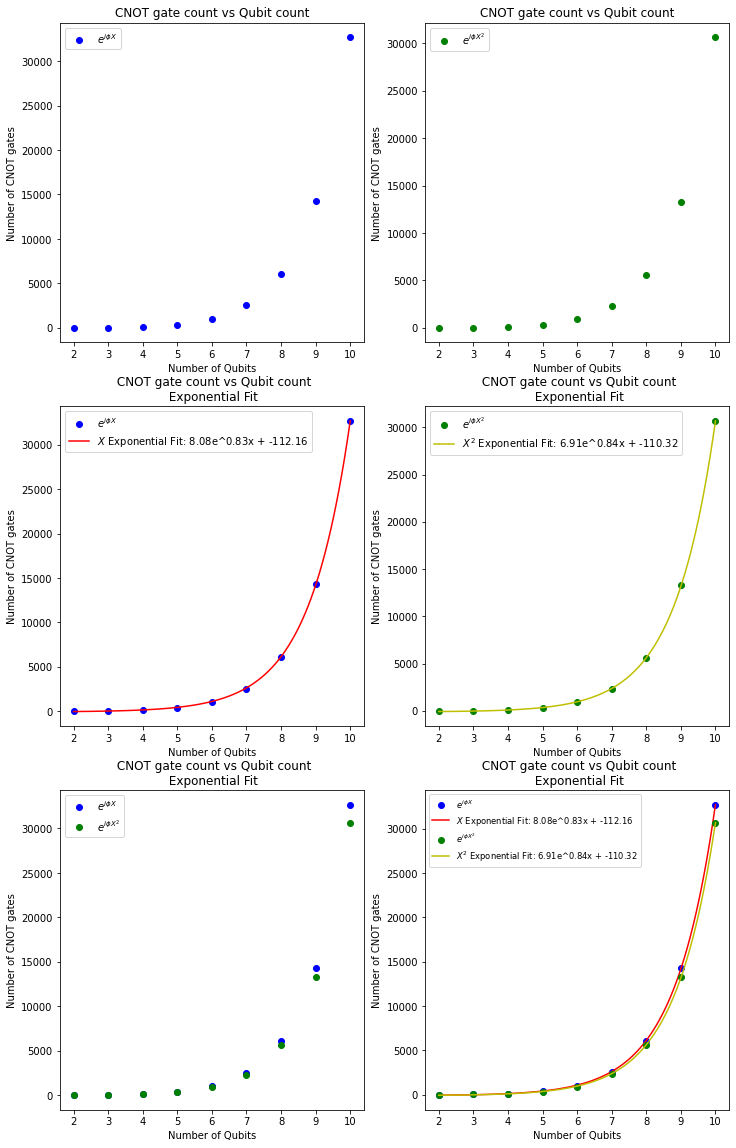

In [23]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#plt.rcParams['text.usetex'] = True


# Define the data
x1 = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10]) # 10 qubits (almost) crashed the kernel
y1 = np.array([6, 34, 124, 372, 1002, 2526, 6096, 14272, 32686])

x2 = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
y2 = np.array([4, 26, 102, 320, 888, 2286, 5602, 13268, 30660])

# Create the grid of plots
fig, axs = plt.subplots(3, 2, figsize=(12, 20))

# Plot the raw data
axs[0, 0].plot(x1, y1, 'bo', label='$e^{i\phi X}$')
axs[0, 0].set_xlabel('Number of Qubits')
axs[0, 0].set_ylabel('Number of CNOT gates')
axs[0, 0].set_title('CNOT gate count vs Qubit count')
axs[0, 0].legend()

axs[0, 1].plot(x2, y2, 'go', label='$e^{i\phi X^2}$')
axs[0, 1].set_xlabel('Number of Qubits')
axs[0, 1].set_ylabel('Number of CNOT gates')
axs[0, 1].set_title('CNOT gate count vs Qubit count')
axs[0, 1].legend()





# Define the exponential function to fit the data
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

# Fit the data with an exponential function 
popt_exp, _ = curve_fit(exponential, x1, y1)
popt_exp2, _2 = curve_fit(exponential, x2, y2)


x_fit = np.linspace(min(x1), max(x1), 100)
y1_fit = exponential(x_fit, *popt_exp)
y2_fit = exponential(x_fit, *popt_exp2)


# Exponential Fit of X
axs[1, 0].plot(x1, y1, 'bo', label='$e^{i\phi X}$')
axs[1, 0].plot(x_fit, y1_fit, 'r-', label=f'$X$ Exponential Fit: {popt_exp[0]:.2f}e^{popt_exp[1]:.2f}x + {popt_exp[2]:.2f}')
axs[1, 0].set_ylabel('Number of CNOT gates')
axs[1, 0].set_xlabel('Number of Qubits')
axs[1, 0].set_title('\n CNOT gate count vs Qubit count\n Exponential Fit')
axs[1, 0].legend()

# Exponential Fit of X^2
axs[1, 1].plot(x1, y2, 'go', label='$e^{i\phi X^2}$')
axs[1, 1].plot(x_fit, y2_fit, 'y-', label=f'$X^2$ Exponential Fit: {popt_exp2[0]:.2f}e^{popt_exp2[1]:.2f}x + {popt_exp2[2]:.2f}')
axs[1, 1].set_xlabel('Number of Qubits')
axs[1, 1].set_ylabel('Number of CNOT gates')
axs[1, 1].set_title('\n CNOT gate count vs Qubit count\n Exponential Fit')
axs[1, 1].legend()








# Overlay the data
axs[2, 0].plot(x1, y1, 'bo', label='$e^{i\phi X}$')
axs[2, 0].plot(x1, y2, 'go', label='$e^{i\phi X^2}$')
axs[2, 0].set_xlabel('Number of Qubits')
axs[2, 0].set_ylabel('Number of CNOT gates')
axs[2, 0].set_title('\n CNOT gate count vs Qubit count\n Exponential Fit')
axs[2, 0].legend()

# Overlay the exponential fits
axs[2, 1].plot(x1, y1, 'bo', label='$e^{i\phi X}$')
axs[2, 1].plot(x_fit, y1_fit, 'r-', label=f'$X$ Exponential Fit: {popt_exp[0]:.2f}e^{popt_exp[1]:.2f}x + {popt_exp[2]:.2f}')
axs[2, 1].plot(x1, y2, 'go', label='$e^{i\phi X^2}$')
axs[2, 1].plot(x_fit, y2_fit, 'y-', label=f'$X^2$ Exponential Fit: {popt_exp2[0]:.2f}e^{popt_exp2[1]:.2f}x + {popt_exp2[2]:.2f}')
axs[2, 1].set_xlabel('Number of Qubits')
axs[2, 1].set_ylabel('Number of CNOT gates')
axs[2, 1].set_title('\n CNOT gate count vs Qubit count\n Exponential Fit')
axs[2, 1].legend(fontsize='small')


# Show all plots
plt.savefig('CNOT_count_X_and_X^2.jpg')
plt.show()



/Users/jonathanraghoonanan/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


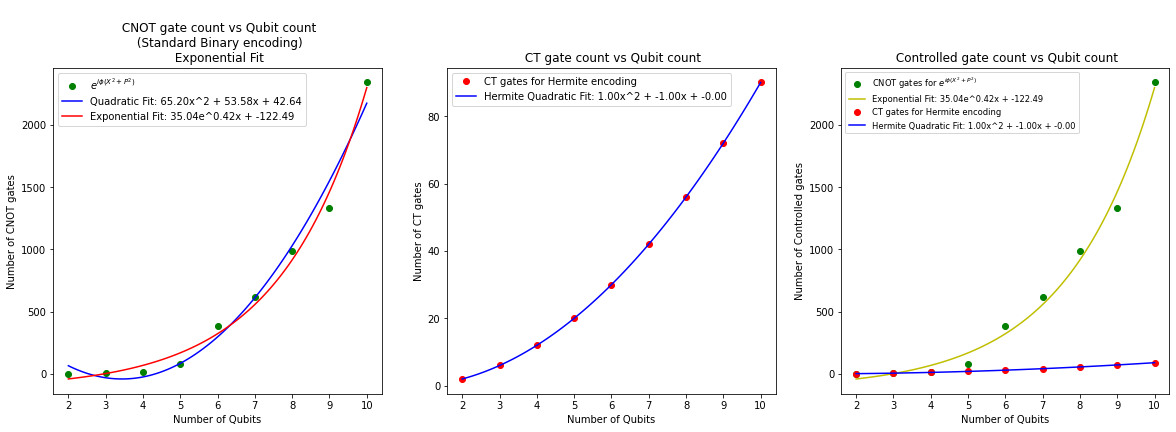

In [29]:
# Number of CT gates for Hermite encoding
# n_x (n_x-1)/2
yH_list = []
for i in x1:
    j=0
    j = 2*.5*i*(i-1)
    yH_list.append(j)
yH = np.array(yH_list)


# Define function for quadratic fit
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c


# Number of CNOT gates for exp(X^2+P^2)
#y3 = np.array([2, 22, 90, 300, 858, 2244, 5588, 13196, 30642])
y3 = np.array([2, 6, 12, 80, 382, 614, 986, 1332, 2340])
popt_exp3, _3 = curve_fit(exponential, x2, y3)
Ham_quad, _4 = curve_fit(quadratic, x2, y3)



# Fit quadratic curve to data
popt_quad, _ = curve_fit(quadratic, x2, yH)
y_quad = quadratic(x_fit, *popt_quad)
y3_fit = exponential(x_fit, *popt_exp3)
Ham_fit = quadratic(x_fit, *Ham_quad)


# Create the grid of plots
fig2, axs2 = plt.subplots(1, 3, figsize=(20, 6))


# Exponential Fit of X^2 + P^2
axs2[0].plot(x1, y3, 'go', label='$e^{i\phi (X^2+P^2)}$')
axs2[0].plot(x_fit, Ham_fit, 'b-', label=f'Quadratic Fit: {Ham_fit[0]:.2f}x^2 + {Ham_fit[1]:.2f}x + {Ham_fit[2]:.2f}')
axs2[0].plot(x_fit, y3_fit, 'r-', label=f'Exponential Fit: {popt_exp3[0]:.2f}e^{popt_exp3[1]:.2f}x + {popt_exp3[2]:.2f}')
axs2[0].set_xlabel('Number of Qubits')
axs2[0].set_ylabel('Number of CNOT gates')
axs2[0].set_title('\n CNOT gate count vs Qubit count\n (Standard Binary encoding)\n Exponential Fit')
axs2[0].legend()


# Hermite Encoding CT count
axs2[1].plot(x1, yH, 'ro', label='CT gates for Hermite encoding')
axs2[1].plot(x_fit, y_quad, 'b-', label=f'Hermite Quadratic Fit: {popt_quad[0]:.2f}x^2 + {popt_quad[1]:.2f}x + {popt_quad[2]:.2f}')
axs2[1].set_xlabel('Number of Qubits')
axs2[1].set_ylabel('Number of CT gates')
axs2[1].set_title('\n CT gate count vs Qubit count')
axs2[1].legend()



# Overlay the X^2 (with exp fit) and the CT count 
axs2[2].plot(x2, y3, 'go', label='CNOT gates for $e^{i\phi (X^2+P^2)}$')
axs2[2].plot(x_fit, y3_fit, 'y-', label=f'Exponential Fit: {popt_exp3[0]:.2f}e^{popt_exp3[1]:.2f}x + {popt_exp3[2]:.2f}')
axs2[2].plot(x2, yH, 'ro', label='CT gates for Hermite encoding')
axs2[2].plot(x_fit, y_quad, 'b-', label=f'Hermite Quadratic Fit: {popt_quad[0]:.2f}x^2 + {popt_quad[1]:.2f}x + {popt_quad[2]:.2f}')
axs2[2].set_xlabel('Number of Qubits')
axs2[2].set_ylabel('Number of Controlled gates')
axs2[2].set_title('\n Controlled gate count vs Qubit count')
axs2[2].legend(fontsize='small')


# Show all three plots
plt.savefig('CT_count_CNOT_comparison.jpg')
#plt.yscale("log")
plt.show()



## Playing with ChatGPT


Note: ChatGPT does not give the same results as I do; I am not sure if there is any validity or insight in the code provided by ChatGPT


"Write code to calculate the number of CNOT gates required to implement second-quantization standard binary encoding in quantum computing"

In [ ]:
def standard_binary_encoding(n, N):
    """
    Returns a list of tuples (i, j, k, l) representing CNOT gates required for
    the second-quantization standard binary encoding of n fermionic modes
    into N qubits. Each tuple represents a CNOT gate with control qubit i and
    target qubit j, and phase factor (-1)^k * i^l.
    """
    encoding = []
    for i in range(n):
        for j in range(i+1, n):
            for k in range(N-1):
                for l in range(2):
                    if (i + j + k + l) % 2 == 1:
                        encoding.append((i, j, k, l))
    return encoding

n = 2  # number of fermionic modes
N = 2  # number of qubits
encoding = standard_binary_encoding(n, N)
num_cnots = len(encoding)
print(f"Number of CNOT gates required: {num_cnots}")

"Write code to calculate the number of CNOT gates required to implement second-quantization standard binary encoding in quantum computing for the operator exp(-i*theta*X)"

In [ ]:
def standard_binary_encoding_exp_x(n):
    """
    Returns the number of CNOT gates required to implement the second-quantization
    standard binary encoding of n fermionic modes into qubits using the operator
    exp(-i*theta*X), where theta is a real number.
    
    Args:
        n (int): The number of fermionic modes.
        
    Returns:
        int: The number of CNOT gates required to implement the circuit.
    """
    num_rx = n*(n-1)
    num_cnot = num_rx
    
    return num_cnot

# Example usage
n = 2
num_cnot = standard_binary_encoding_exp_x(n)
print(f"The number of CNOT gates for {n} modes is {num_cnot}.")
